In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys


In [2]:
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import text as mtext
import numpy as np
import math

class CurvedText(mtext.Text):
    """
    A text object that follows an arbitrary curve.
    """
    def __init__(self, x, y, text, axes, **kwargs):
        super(CurvedText, self).__init__(x[0],y[0],' ', **kwargs)

        axes.add_artist(self)

        ##saving the curve:
        self.__x = x
        self.__y = y
        self.__zorder = self.get_zorder()

        ##creating the text objects
        self.__Characters = []
        for c in text:
            if c == ' ':
                ##make this an invisible 'a':
                t = mtext.Text(0,0,'a')
                t.set_alpha(0.0)
            else:
                t = mtext.Text(0,0,c, **kwargs)

            #resetting unnecessary arguments
            t.set_ha('center')
            t.set_rotation(0)
            t.set_zorder(self.__zorder +1)

            self.__Characters.append((c,t))
            axes.add_artist(t)


    ##overloading some member functions, to assure correct functionality
    ##on update
    def set_zorder(self, zorder):
        super(CurvedText, self).set_zorder(zorder)
        self.__zorder = self.get_zorder()
        for c,t in self.__Characters:
            t.set_zorder(self.__zorder+1)

    def draw(self, renderer, *args, **kwargs):
        """
        Overload of the Text.draw() function. Do not do
        do any drawing, but update the positions and rotation
        angles of self.__Characters.
        """
        self.update_positions(renderer)

    def update_positions(self,renderer):
        """
        Update positions and rotations of the individual text elements.
        """

        #preparations

        ##determining the aspect ratio:
        ##from https://stackoverflow.com/a/42014041/2454357

        ##data limits
        xlim = self.axes.get_xlim()
        ylim = self.axes.get_ylim()
        ## Axis size on figure
        figW, figH = self.axes.get_figure().get_size_inches()
        ## Ratio of display units
        _, _, w, h = self.axes.get_position().bounds
        ##final aspect ratio
        aspect = ((figW * w)/(figH * h))*(ylim[1]-ylim[0])/(xlim[1]-xlim[0])

        #points of the curve in figure coordinates:
        x_fig,y_fig = (
            np.array(l) for l in zip(*self.axes.transData.transform([
            (i,j) for i,j in zip(self.__x,self.__y)
            ]))
        )

        #point distances in figure coordinates
        x_fig_dist = (x_fig[1:]-x_fig[:-1])
        y_fig_dist = (y_fig[1:]-y_fig[:-1])
        r_fig_dist = np.sqrt(x_fig_dist**2+y_fig_dist**2)

        #arc length in figure coordinates
        l_fig = np.insert(np.cumsum(r_fig_dist),0,0)

        #angles in figure coordinates
        rads = np.arctan2((y_fig[1:] - y_fig[:-1]),(x_fig[1:] - x_fig[:-1]))
        degs = np.rad2deg(rads)


        rel_pos = 10
        for c,t in self.__Characters:
            #finding the width of c:
            t.set_rotation(0)
            t.set_va('center')
            bbox1  = t.get_window_extent(renderer=renderer)
            w = bbox1.width
            h = bbox1.height

            #ignore all letters that don't fit:
            if rel_pos+w/2 > l_fig[-1]:
                t.set_alpha(0.0)
                rel_pos += w
                continue

            elif c != ' ':
                t.set_alpha(1.0)

            #finding the two data points between which the horizontal
            #center point of the character will be situated
            #left and right indices:
            il = np.where(rel_pos+w/2 >= l_fig)[0][-1]
            ir = np.where(rel_pos+w/2 <= l_fig)[0][0]

            #if we exactly hit a data point:
            if ir == il:
                ir += 1

            #how much of the letter width was needed to find il:
            used = l_fig[il]-rel_pos
            rel_pos = l_fig[il]

            #relative distance between il and ir where the center
            #of the character will be
            fraction = (w/2-used)/r_fig_dist[il]

            ##setting the character position in data coordinates:
            ##interpolate between the two points:
            x = self.__x[il]+fraction*(self.__x[ir]-self.__x[il])
            y = self.__y[il]+fraction*(self.__y[ir]-self.__y[il])

            #getting the offset when setting correct vertical alignment
            #in data coordinates
            t.set_va(self.get_va())
            bbox2  = t.get_window_extent(renderer=renderer)

            bbox1d = self.axes.transData.inverted().transform(bbox1)
            bbox2d = self.axes.transData.inverted().transform(bbox2)
            dr = np.array(bbox2d[0]-bbox1d[0])

            #the rotation/stretch matrix
            rad = rads[il]
            rot_mat = np.array([
                [math.cos(rad), math.sin(rad)*aspect],
                [-math.sin(rad)/aspect, math.cos(rad)]
            ])

            ##computing the offset vector of the rotated character
            drp = np.dot(dr,rot_mat)

            #setting final position and rotation:
            t.set_position(np.array([x,y])+drp)
            t.set_rotation(degs[il])

            t.set_va('center')
            t.set_ha('center')

            #updating rel_pos to right edge of character
            rel_pos += w-used



In [3]:
# Function to calculate the expected change in allele frequency due to directional selection and stabilizing selection
def change_in_allele_frequency(a,x,D,N):
    return a*x*(1-x)/(2*N)*(D-a*(1/2-x))

def realized_allele_frequency(a,x,D,N,method='deterministic'):
    delta_p = change_in_allele_frequency(a,x,D,N)
    if method == 'deterministic':
        new_x = x + delta_p
        if new_x < 0:
            return 0,-x
        elif new_x > 1:
            return 1,1-x
        else:
            return new_x, delta_p
    elif method == 'stochastic':
        p_prime = x + delta_p
        new_x = np.random.binomial(2*N, p_prime)/(2*N)
        return new_x, new_x - x
    else:
        raise ValueError("Method must be either 'deterministic' or 'stochastic'")

def recursion(a,x0,shift,N,sigma2, stopping_function,method='deterministic',max_gen = 20000):
    x = x0
    x_trajectory = [x]
    d_trajectory = [shift]
    while not stopping_function(x):
        d = d_trajectory[-1]
        x, delta = realized_allele_frequency(a=a,x=x,D=d,N=N,method=method)
        x_trajectory.append(x)
        d -= delta*2*a+sigma2*d/(2*N)
        d_trajectory.append(d)
        if len(x_trajectory) > max_gen:
            print("Warning: Maximum number of generations reached in recursion")
            break
    return np.array(x_trajectory), np.array(d_trajectory)


In [4]:
def stopping_function_stochastic(x):
    return x == 0 or x == 1

def stopping_function_deterministic(x):
    return x < 1e-6 or x > 1-1e-6


In [5]:
# Functions to check for strong selection and overshooting
def check_for_strong_selection(x_trajectory,d_trajectory,a):
    for x,d in zip(x_trajectory,d_trajectory):
        if a*(d-a*(1/2-x)) < 10:
            return False
    return True

def check_for_overshooting(d_trajectory):
    for i in d_trajectory:
        if i < 0:
            return True
    return False

# Functions to find thresholds using binary search
# Find the maximum initial shift that leads to overshooting and strong selection
def find_overshooting_threshold(x0,a,N,sigma2,method='deterministic',min_shift = 0, max_shift = 100,verbose=False):
    current_shift = (min_shift + max_shift)/2
    if max_shift - min_shift < 1e-3:
        return current_shift
    x_trajectory, d_trajectory = recursion(a=a,x0=x0,shift=current_shift,N=N,sigma2=sigma2,stopping_function=stopping_function_deterministic if method=='deterministic' else stopping_function_stochastic,method=method)
    strong_selection = check_for_strong_selection(x_trajectory,d_trajectory,a)
    overshooting = check_for_overshooting(d_trajectory)
    
    if verbose:
        print(f"Current shift: {current_shift}, Strong selection: {strong_selection}, Overshooting: {overshooting}, Min shift: {min_shift}, Max shift: {max_shift}")
        print(f"x trajectory: {x_trajectory}")
        print(f"d trajectory: {d_trajectory}")
    if not strong_selection:
        min_shift = current_shift
    elif overshooting:
        min_shift = current_shift
    else:
        max_shift = current_shift
    return find_overshooting_threshold(x0=x0,a=a,N=N,sigma2=sigma2,method=method,min_shift=min_shift,max_shift=max_shift)

# Find the maximum initial shift that leads to strong selection
def find_strong_selection_threshold(x0,a,N,sigma2,method='deterministic',min_shift = 0, max_shift = 100):
    current_shift = (min_shift + max_shift)/2
    if max_shift - min_shift < 1e-3:
        return current_shift
    x_trajectory, d_trajectory = recursion(a=a,x0=x0,shift=current_shift,N=N,sigma2=sigma2,stopping_function=stopping_function_deterministic if method=='deterministic' else stopping_function_stochastic,method=method)
    strong_selection = check_for_strong_selection(x_trajectory,d_trajectory,a)
    if strong_selection:
        max_shift = current_shift
    else:
        min_shift = current_shift
        
    return find_strong_selection_threshold(x0=x0,a=a,N=N,sigma2=sigma2,method=method,min_shift=min_shift,max_shift=max_shift)

# Find the minimum initial shift that leads to fixation
def find_fixation_threshold(x0,a,N,sigma2,method='deterministic',min_shift=0,max_shift=100):
    current_shift = (min_shift + max_shift)/2
    if max_shift - min_shift < 1e-3:
        return current_shift
    x_trajectory, d_trajectory = recursion(a=a,x0=x0,shift=current_shift,N=N,sigma2=sigma2,stopping_function=stopping_function_deterministic if method=='deterministic' else stopping_function_stochastic,method=method)
    if x_trajectory[-1] >= 0.5:
        max_shift = current_shift
    else:
        min_shift = current_shift
    return find_fixation_threshold(x0=x0,a=a,N=N,sigma2=sigma2,method=method,min_shift=min_shift,max_shift=max_shift)

# Threshold for immediate extinction
def find_extinction_threshold(x0,a):
    return a*(1/2-x0)

a = 14
sigma2 = 6
x0 = 1/a**2
N = 5000
find_overshooting_threshold(x0,a,N,sigma2,method='deterministic',min_shift = 0, max_shift = 100,verbose=True)


Current shift: 50.0, Strong selection: True, Overshooting: False, Min shift: 0, Max shift: 100
x trajectory: [0.00510204 0.00540812 0.00573221 0.00607533 0.00643858 0.00682308
 0.00723006 0.00766077 0.00811657 0.00859885 0.00910911 0.0096489
 0.01021986 0.01082373 0.01146232 0.01213753 0.01285138 0.01360596
 0.01440348 0.01524626 0.01613671 0.01707739 0.01807096 0.01912019
 0.02022799 0.02139741 0.02263162 0.02393394 0.0253078  0.02675682
 0.02828471 0.02989538 0.03159284 0.03338129 0.03526505 0.0372486
 0.03933656 0.04153372 0.04384497 0.04627537 0.04883009 0.05151444
 0.05433385 0.05729383 0.06040002 0.06365811 0.06707387 0.07065312
 0.07440171 0.0783255  0.08243033 0.086722   0.09120625 0.09588871
 0.10077489 0.10587013 0.11117956 0.11670809 0.12246033 0.12844058
 0.13465277 0.14110043 0.14778661 0.15471391 0.16188436 0.1692994
 0.17695986 0.18486592 0.19301702 0.20141191 0.21004853 0.21892407
 0.22803489 0.23737654 0.2469437  0.25673026 0.26672925 0.27693288
 0.28733256 0.29791894 

31.489181518554688

In [6]:
a2 = 200
a = np.sqrt(a2)
N = 5000
x0 = 1/a2
sigma2_values = np.array([0.1]+list(np.linspace(1,100,200)))
thresholds = {}
for threshold_function in [find_overshooting_threshold, find_strong_selection_threshold, find_fixation_threshold]:
    thresholds[threshold_function.__name__] = []
    print(threshold_function.__name__)
    for sigma2 in sigma2_values:
        print(sigma2)
        thresh = threshold_function(x0=x0,a=a,N=N,sigma2=sigma2,method='deterministic',min_shift = 0, max_shift = 100)
        thresholds[threshold_function.__name__].append(thresh)
    thresholds[threshold_function.__name__] = np.array(thresholds[threshold_function.__name__])

thresholds['find_extinction_threshold'] = np.array([find_extinction_threshold(x0,a)]*len(sigma2_values))


find_overshooting_threshold
0.1
1.0
1.4974874371859297
1.9949748743718594
2.492462311557789
2.9899497487437188
3.487437185929648
3.9849246231155777
4.482412060301508
4.9798994974874375
5.477386934673366
5.974874371859296
6.472361809045226
6.969849246231155
7.467336683417085
7.964824120603015
8.462311557788944


8.959798994974875
9.457286432160803
9.954773869346733
10.452261306532662
10.949748743718592
11.447236180904522
11.944723618090451
12.442211055276381
12.93969849246231
13.43718592964824
13.93467336683417
14.4321608040201
14.92964824120603
15.42713567839196
15.924623115577889
16.42211055276382
16.91959798994975
17.417085427135678
17.914572864321606
18.412060301507537
18.909547738693465
19.407035175879397
19.904522613065325
20.402010050251256
20.899497487437184
21.396984924623116
21.894472361809044
22.391959798994975
22.889447236180903
23.386934673366834
23.884422110552762
24.381909547738694
24.87939698492462
25.376884422110553
25.87437185929648
26.371859296482413
26.86934673366834
27.366834170854272
27.8643216080402
28.36180904522613
28.85929648241206
29.35678391959799
29.85427135678392
30.35175879396985
30.849246231155778
31.34673366834171
31.844221105527637
32.34170854271357
32.8391959798995
33.336683417085425
33.834170854271356
34.33165829145729
34.82914572864321
35.32663316582914
35.

In [50]:
def create_phase_panel(ax,thresholds,sigma2_values,a,N,x0):
    # order of thresholds: overshooting, strong selection, fixation, extinction
    # should fill between 100 and overshooting, overshooting and strong selection, strong selection and fixation, fixation and extinction, extinction and 0
    overshoot = thresholds['find_overshooting_threshold']/a
    strong_sel = thresholds['find_strong_selection_threshold']/a
    fixation = thresholds['find_fixation_threshold']/a
    extinction = thresholds['find_extinction_threshold']/a
    upper_boundary = np.array([100]*len(sigma2_values))/a
    lower_boundary = np.array([0]*len(sigma2_values))/a
    
    # Fill between regions
    alpha=1
    # define colors for each region. Overshoot should be dark red, strong selection orange, fixation green, extinction blue, no adaptation dark grey
    overshoot_color = [0.8,0.3,0.3]
    strong_sel_color = [1,0.7,0.3]
    fixation_color = [0.3,0.7,0.3]
    extinction_color = [0.3,0.5,1]
    no_adaptation_color = [0.5,0.5,0.5]
    
    sigma2_values_scaled = sigma2_values/a**2
    sigma2_values_scaled[0] = 0
    ax.fill_between(sigma2_values_scaled, upper_boundary, overshoot, color=overshoot_color, alpha=alpha, label='Overshooting')
    ax.fill_between(sigma2_values_scaled, overshoot, strong_sel, color=strong_sel_color, alpha=alpha, label='Strong selection')
    ax.fill_between(sigma2_values_scaled, strong_sel, fixation, color=fixation_color, alpha=alpha, label='Fixation')
    ax.fill_between(sigma2_values_scaled, fixation, extinction, color=extinction_color, alpha=alpha, label='Extinction')
    ax.fill_between(sigma2_values_scaled, extinction, lower_boundary, color=no_adaptation_color, alpha=alpha, label='No adaptation')
    
    # ax.plot(sigma2_values, overshoot, color='red', label='Overshooting threshold')
    # ax.plot(sigma2_values, strong_sel, color='orange', label='Strong selection threshold')
    # ax.plot(sigma2_values, fixation, color='green', label='Fixation threshold')
    # ax.plot(sigma2_values, extinction, color='blue', label='Extinction threshold') 

    ax.set_xlabel(r'Background variance (units of $a^2$)')
    ax.set_ylabel(r'Shift size (units of $a$)',labelpad=0)
    ax.set_title(r'$\bf{E.}$ Phase space of allelic trajectories')
    ax.set_xlim(sigma2_values_scaled[0], sigma2_values_scaled[-1])
    ax.set_ylim(lower_boundary[0], upper_boundary[0])
    # ax.legend(loc='upper right')

    start_index = 2
    CurvedText(x=sigma2_values_scaled[start_index:], y=overshoot[start_index:]+0.15, text='Sweep with overshooting', axes=ax, color=list(np.array(strong_sel_color)*1), fontsize=11)
    CurvedText(x=sigma2_values_scaled[start_index:], y=strong_sel[start_index:]+0.15, text='Partial sweep and overshooting', axes=ax, color=list(np.array(fixation_color)*0.8), fontsize=11)
    CurvedText(x=sigma2_values_scaled[start_index:], y=fixation[start_index:]-0.4, text='Establishment and loss', axes=ax, color=list(np.array(extinction_color)*0.5), fontsize=11)
    CurvedText(x=sigma2_values_scaled[start_index:], y=extinction[start_index:]-0.4, text='Quick loss', axes=ax, color='k', fontsize=11)
    CurvedText(x=sigma2_values_scaled[start_index:], y=upper_boundary[start_index:]-0.4, text='Sweep without overshooting', axes=ax, color=list(np.array(overshoot_color)*0.5), fontsize=11)



In [51]:
def plot_deterministic_trajectories(ax_x,ax_d,a,N,sigma2,shifts,x0):
    overshoot_color = [0.8,0.3,0.3]
    strong_sel_color = [1,0.7,0.3]
    fixation_color = [0.3,0.7,0.3]
    extinction_color = [0.3,0.5,1]
    no_adaptation_color = 'k'
    
    max_freqs = []
    
    for shift,color in zip(shifts,[overshoot_color,strong_sel_color,fixation_color,extinction_color,no_adaptation_color]):
        x_trajectory, d_trajectory = recursion(a=a,x0=x0,shift=shift,N=N,sigma2=sigma2,stopping_function=stopping_function_deterministic,method='deterministic')
        if color != no_adaptation_color:
            x_time = np.linspace(0,len(x_trajectory),len(x_trajectory))/(2*N)*sigma2
            ax_x.plot(x_time,x_trajectory, color=color,lw=2)
        d_time = np.linspace(0,len(d_trajectory),len(d_trajectory))
        min_d_length = int(10/sigma2*2*N)
        t_extension = np.linspace(0,max(1,min_d_length - len(d_trajectory)),100)
        d = d_trajectory[-1]
        d_extension = np.exp(-sigma2/(2*N)*t_extension)*d
        d_trajectory = np.append(d_trajectory, d_extension[1:])
        t_extension = t_extension+d_time[-1]
        d_time = np.append(d_time, t_extension[1:])*sigma2/(2*N)
        max_freqs.append(max(x_trajectory))
        ax_d.plot(d_time,d_trajectory/shift, color=color,lw=2)
    
    return max_freqs
    
def plot_stochastic_trajectories(ax_x,ax_d,a,N,sigma2,shifts,x0,max_freqs,apply_min_length=False):
    overshoot_color = [0.8,0.3,0.3]
    strong_sel_color = [1,0.7,0.3]
    fixation_color = [0.3,0.7,0.3]
    extinction_color = [0.3,0.5,1]
    no_adaptation_color = [0.5,0.5,0.5]

    for shift,color,mandatory_outcome,minimum_maximum_frequency,min_length in zip(shifts,[overshoot_color,strong_sel_color,fixation_color,extinction_color,no_adaptation_color],[1,1,1,0,0],max_freqs,[0,0,8,0,0]):
        i = 0
        while i < 5:
            x_trajectory, d_trajectory = recursion(a=a,x0=x0,shift=shift,N=N,sigma2=sigma2,stopping_function=stopping_function_deterministic,method='stochastic')
            min_d_length = int(12/sigma2*2*N)
            if x_trajectory[-1] != mandatory_outcome:
                continue
            if max(x_trajectory) < minimum_maximum_frequency:
                continue
            if len(x_trajectory) > min_d_length:
                continue
            if apply_min_length and len(x_trajectory)*sigma2/(2*N)<min_length:
                continue
            if min_length > 0 and apply_min_length:
                time4 = int(4*2*N/sigma2)
                if x_trajectory[time4] > 0.8:
                    continue
            i += 1
            if color != no_adaptation_color:
                x_time = np.linspace(0,len(x_trajectory),len(x_trajectory))/(2*N)*sigma2
                ax_x.plot(x_time,x_trajectory, color=color,lw=2,alpha=0.2)
            # extend d_trajectory until it has length greater than 10/sigma2*2*N
            d_time = np.linspace(0,len(d_trajectory),len(d_trajectory))
            t_extension = np.linspace(0,max(1,min_d_length - len(d_trajectory)),100)
            d = d_trajectory[-1]
            d_extension = np.exp(-sigma2/(2*N)*t_extension)*d
            d_trajectory = np.append(d_trajectory, d_extension[1:])
            t_extension = t_extension+d_time[-1]
            d_time = np.append(d_time, t_extension[1:])*sigma2/(2*N)
            
            d_trajectory = d_trajectory/shift
            ax_d.plot(d_time,d_trajectory, color=color,lw=2,alpha=0.2)
            

    if sigma2 < 4:
        ax_x.set_xlim(0,1)
        ax_d.set_xlim(0,1)
        # set x ticks to 0,0.5,1,1.5
        ax_x.set_xticks([0,0.5,1])
        ax_x.set_xticklabels(['0','0.5','1'])
        ax_d.set_xticks([0,0.5,1])
        ax_d.set_xticklabels(['0','0.5','1'])
    else:
        ax_x.set_xlim(0,10)
        ax_d.set_xlim(0,10)
        # set x ticks to 0,4,8,12
        ax_x.set_xticks([0,4,8,12])
        ax_x.set_xticklabels(['0','4','8','12'])
        ax_d.set_xticks([0,4,8,12])
        ax_d.set_xticklabels(['0','4','8','12'])
    ax_x.set_xlabel(r'Time (units of $V_S/\sigma^2$)')
    ax_x.set_ylabel('Allele frequency',labelpad=0)
    ax_d.set_xlabel(r'Time (units of $V_S/\sigma^2$)')
    ax_d.set_ylabel(r'Distance ($D / \Lambda$)',labelpad=0)
    ax_x.set_ylim(0,1)
    ax_d.set_ylim(-0.4,1)
    # set ax_x y ticks to 0,0.5,1
    ax_x.set_yticks([0,0.5,1])
    ax_x.set_yticklabels(['0',r'$\frac{1}{2}$','1'])
    ax_d.set_yticks([0,0.5,1])
    ax_d.set_yticklabels(['0',r'$\frac{1}{2}$','1'])
    



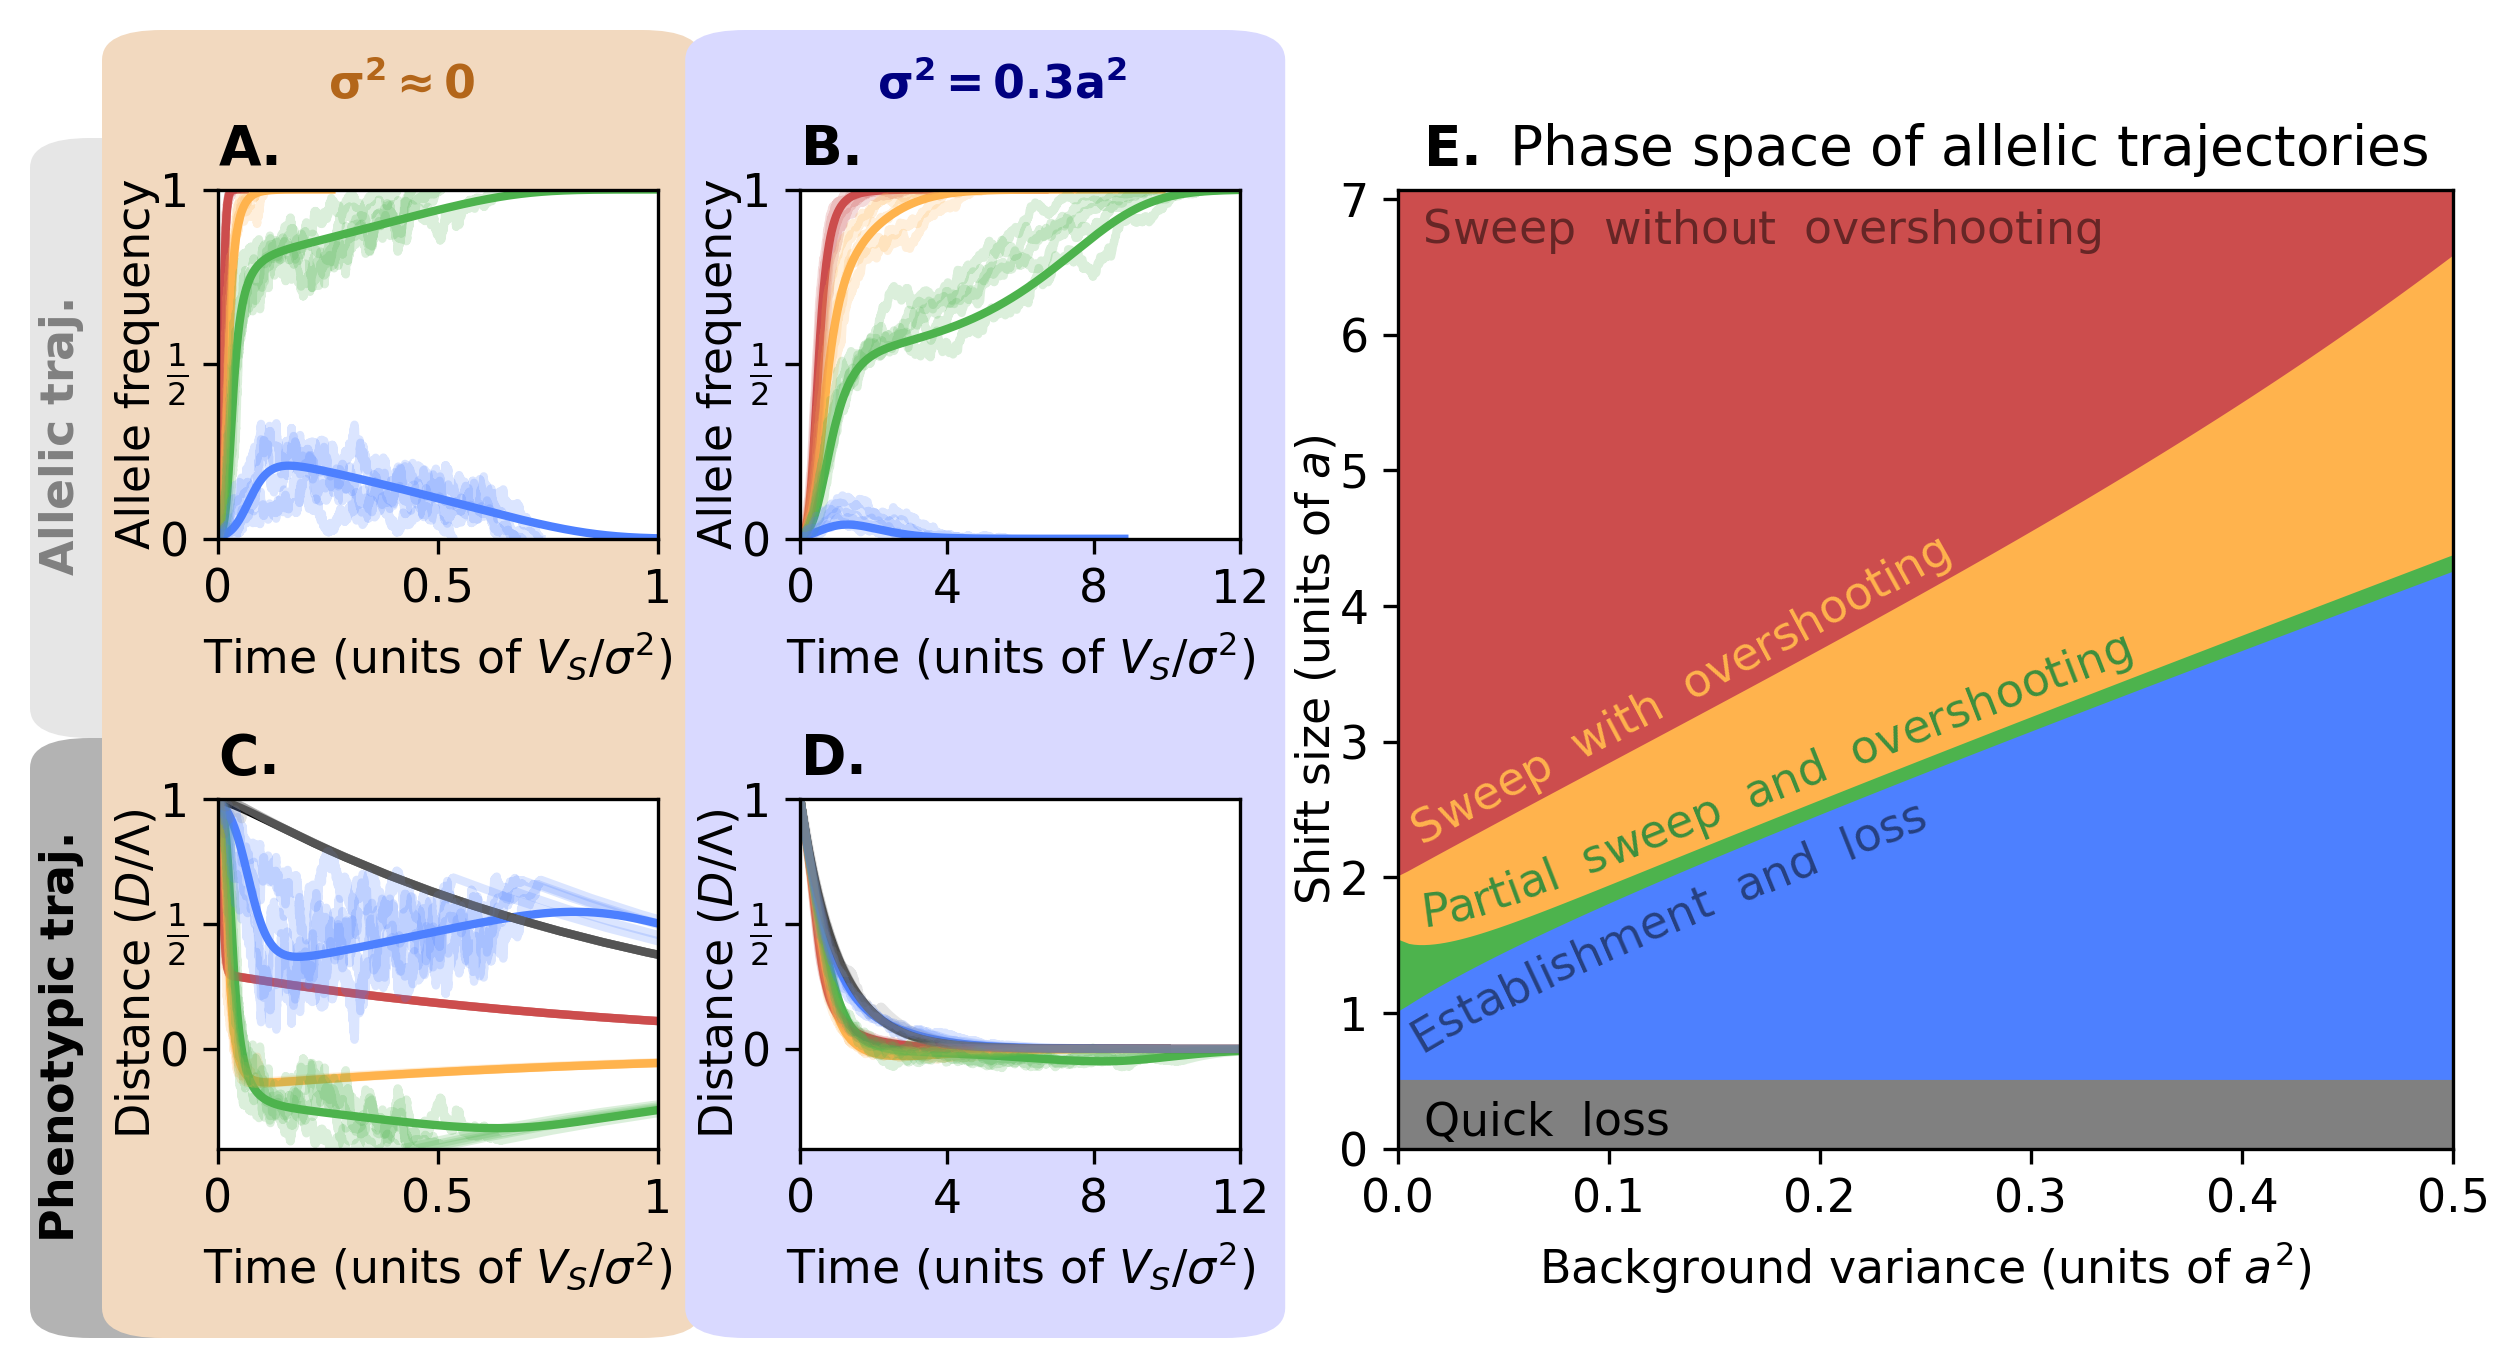

In [55]:

# plotting
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.size'] = 11

# create a grid of figures: one large 2x2 panel (ax1) and four small 1x1 panels (ax2-ax5) to the right
fig = plt.figure(constrained_layout=True, figsize=(8, 4))
gs = fig.add_gridspec(2, 22)

# Large 2x2 panel spanning the left two columns
ax1 = fig.add_subplot(gs[:, 10:22])

# Four 1x1 panels stacked in two columns on the right
ax2 = fig.add_subplot(gs[0, 0:5])
ax3 = fig.add_subplot(gs[0, 5:10])
ax4 = fig.add_subplot(gs[1, 0:5])
ax5 = fig.add_subplot(gs[1, 5:10])

create_phase_panel(ax1,thresholds,sigma2_values,a,N,x0)
ax1.set_xlim(0,0.5)
np.random.seed(116)
for sigma2_value,ax_x,ax_d,apply_min_length in zip([1,60],[ax2,ax3],[ax4,ax5],[False,True]):
    sigma2_index = np.where(sigma2_values > sigma2_value)[0][0]
    shift_values = [(100+5*thresholds['find_overshooting_threshold'][sigma2_index])/6, 
                    (thresholds['find_overshooting_threshold'][sigma2_index]+thresholds['find_strong_selection_threshold'][sigma2_index])/2, 
                    (thresholds['find_strong_selection_threshold'][sigma2_index]*2+thresholds['find_fixation_threshold'][sigma2_index])/3,
                    (thresholds['find_fixation_threshold'][sigma2_index]+thresholds['find_extinction_threshold'][sigma2_index])/2, 
                    thresholds['find_extinction_threshold'][sigma2_index]*0.8]
    max_freqs = plot_deterministic_trajectories(ax_x = ax_x, ax_d = ax_d, a=a, N=N, sigma2=sigma2_value, shifts=shift_values, x0=x0)
    plot_stochastic_trajectories(ax_x = ax_x, ax_d = ax_d, a=a, N=N, sigma2=sigma2_value, shifts=shift_values, x0=x0, apply_min_length=apply_min_length,max_freqs=max_freqs)

ax2.set_title(r'$\bf{A.}$',loc='left')
ax3.set_title(r'$\bf{B.}$',loc='left')
ax4.set_title(r'$\bf{C.}$',loc='left')
ax5.set_title(r'$\bf{D.}$',loc='left')

dark_orange_color = [0.7,0.4,0.1]
from matplotlib.patches import Rectangle, FancyBboxPatch
fig.patches.extend([FancyBboxPatch((-0.03,-0.025),5.5/22,0.5, boxstyle='Round, pad=0,rounding_size=0.025', mutation_aspect=1,facecolor=[0.7,0.7,0.7],edgecolor='None',clip_on=False,transform=fig.transFigure, figure=fig,zorder=-1)])
fig.patches.extend([FancyBboxPatch((-0.03,0.475),5.5/22,0.5, boxstyle='Round, pad=0,rounding_size=0.025', mutation_aspect=1,facecolor=[0.9,0.9,0.9],edgecolor='None',clip_on=False,transform=fig.transFigure, figure=fig,zorder=-1)])
fig.patches.extend([FancyBboxPatch((0,-0.025),5.5/22,1.09, boxstyle='Round, pad=0,rounding_size=0.025', mutation_aspect=1,facecolor=[0.95,0.85,0.75],edgecolor='None',clip_on=False,transform=fig.transFigure, figure=fig,zorder=-1)])
fig.patches.extend([FancyBboxPatch((5.5/22-0.007,-0.025),5.5/22,1.09, boxstyle='Round, pad=0,rounding_size=0.025', mutation_aspect=1,facecolor=[0.85,0.85,1],edgecolor='None',clip_on=False,transform=fig.transFigure, figure=fig,zorder=-1)])

fig.text(5.5/22/2*3,1.0,r'$\bf{\sigma^2=0.3a^2}$',ha='center',va='bottom',fontsize=11,color='navy')
fig.text(5.5/22/2,1.0,r'$\bf{\sigma^2 \approx 0}$',ha='center',va='bottom',fontsize=11,color=dark_orange_color)
fig.text(-0.027,0.475+0.5/2,r'$\bf{Allelic}$'+' '+ r'$\bf{traj.}$',ha='left',va='center',fontsize=11,rotation=90,color=[0.5,0.5,0.5])
fig.text(-0.027,-0.025+0.5/2,r'$\bf{Phenotypic}$'+' '+ r'$\bf{traj.}$',ha='left',va='center',fontsize=11,rotation=90,color='k')

fig.savefig('Supplementary_figure_5.png',dpi=300,bbox_inches='tight')
